In [1]:
import sys
sys.path.append("../")

import ROOT
import numpy as np
import matplotlib.pyplot as plt
import os

Welcome to JupyROOT 6.27/01


In [17]:
e_fhc = "./neutrinos/comb_rtd/electron_fhc_files.root"
tf = ROOT.TFile(e_fhc, "READ")
mt = tf.metadata
evts = mt.GetEntries()
# mt.Print()
for evt in mt:
    xpix = evt.xpos/4.
    ypix = evt.ypos/4.
    break
print("pixel:", xpix, ypix)
channelYdim, channelXdim = 4, 4
asicX = xpix/channelXdim
asicY = ypix/channelYdim
print("asic:", asicX, asicY)

tileSizes = [[4,4], [8,8], [10,14], [16,16]]
for tile in tileSizes:
    print(f"{asicX/tile[0]} {asicY/tile[1]} {asicX%tile[0]} {asicY%tile[1]}")

pixel: 300.0 800.0
asic: 75.0 200.0
18.75 50.0 3.0 0.0
9.375 25.0 3.0 0.0
7.5 14.285714285714286 5.0 4.0
4.6875 12.5 11.0 8.0


### Like neutrinosAna but reading the full had files individually

In [3]:
ROOT.EnableImplicitMT()
erdf = ROOT.RDataFrame("event_tree", e_fhc)
# print("got counts:", erdf.Count().GetValue())

### List Branches

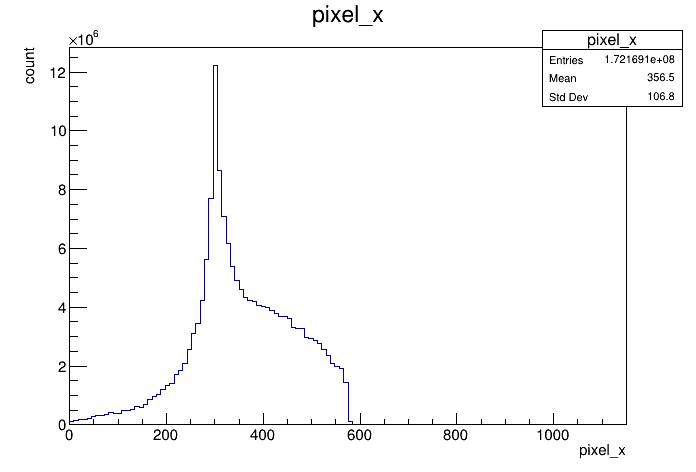

In [4]:
# cols = erdf.GetColumnNames()
# print(len(cols))
# for r in cols:
#     print(r)
c = ROOT.TCanvas()
h = erdf.Histo1D("pixel_x")
h.Draw()
c.Draw()

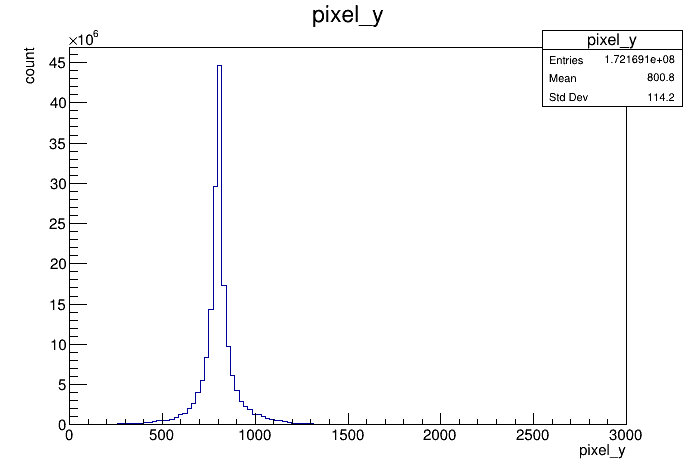

In [5]:
c = ROOT.TCanvas()
h = erdf.Histo1D("pixel_y")
h.Draw()
c.Draw()

### Define Columns

found keys: ['aelectron_fhc', 'aelectron_rhc', 'amuon_fhc', 'amuon_rhc', 'electron_fhc', 'electron_rhc', 'muon_fhc', 'muon_rhc']


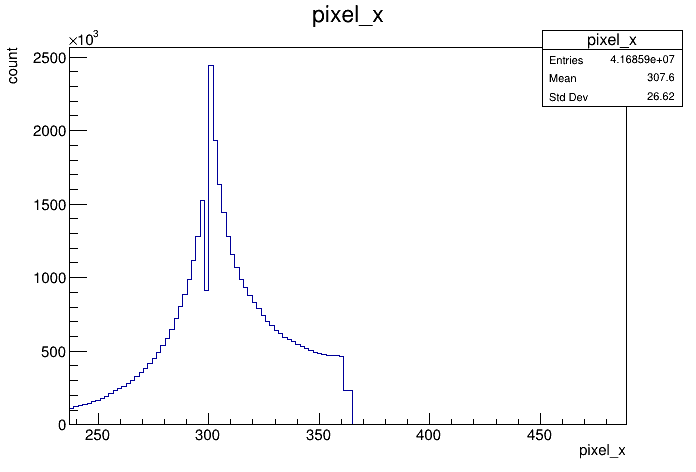

In [14]:
dir = "./neutrinos/comb_rtd"
nu_files = os.listdir(dir)
nu_files = [os.path.join(dir, f) for f in nu_files]
nu_keys = [ f.split('/')[-1].split('.')[0][:-6] for f in nu_files ]
print(f"found keys: {nu_keys}")
# filter the base rdfs for time and for size
xpos, ypos = 300, 800
cols = ["pixel_x", "pixel_y", "pixel_reset", "axis_x", "axis_y", "axis_z", "xpos", "ypos", "zpos", "nEvt", "lepKE"]
tile_set = f"pixel_x < {xpos} + 64 && pixel_x > {xpos} - 64 && pixel_y < {ypos} + 64 && pixel_y > {ypos} - 64"  
nu_rdfs = [ ROOT.RDataFrame("event_tree", f, cols).Filter("pixel_reset < 1e-1").Filter(tile_set) for f in nu_files ]
c = ROOT.TCanvas()
h = nu_rdfs[4].Histo1D("pixel_x")
h.Draw()
c.Draw()

In [11]:
# dictionary of the RDFs
d_rdfs = { k:v for k, v in zip(nu_keys, nu_rdfs) }

# file breaks up into FHC and nu-type

# break up into zpos
zpos = ["100", "800", "1800", "2800", "3500"]
d_zpos = {k1:{ z:rdf.Filter(f"zpos == {z}") for z in zpos } for k1, rdf in d_rdfs.items()}

# break up into angle
theta = ["1", "2", "3", "4", "5"]
t_xyz = [ [1,0,0], [10000,0,349], [10000, 0, -349], [0,0,1], [0,0,-1] ]
d_theta = {k1:{k:{t:d_df.Filter(f"axis_x == {x} && axis_y == {y} && axis_z == {z}") for t, (x,y,z) in zip(theta, t_xyz)} for k,d_df in v1.items()} for k1,v1 in d_zpos.items()}

# break up into energy
energy = [str(en) for en in range(250,10001,250)]
d_ens = {k0:{k1:{k2:{en:d_df.Filter(f"fsEnergy == {en}") for en in energy} for k2,d_df in v1.items()} for k1,v1 in v0.items()} for k0, v0 in d_theta.items()}

# test
x, d = [], []
print(f"plotting for energy: ", end=" ")
for en in energy[:5]:
    print(f"{en}", end=" ")
    x.append(int(en)) 
    d.append(d_ens['electron_fhc']['800']['1'][en].Count().GetValue())

# bin number of resets as a function of energy

# average local depth as energy

# relate remote depth and local depth

plotting for energy:  250 500 750 1000 1250 

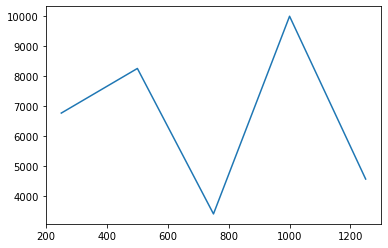

In [12]:
plt.plot(x,d)

### qpasic sim columns

In [8]:
# break up into tiles
tiles = ["Tile4", "Tile8", "Tile10", "Tile16"]
n_tiles = set()
# for i in range(1,1501):
